### Telco Churn

Detecting how long a customer lasts with a telco company and implementing a survival regression model.

The `data/telco_churn.csv` dataset comes from [here](https://www.kaggle.com/blastchar/telco-customer-churn) and here is the description:
**Context**

"Predict behavior to retain customers. You can analyze all relevant customer data and develop focused customer retention programs." [IBM Sample Data Sets]
Content

Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The data set includes information about:

- Customers who left within the last month – the column is called Churn
- Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
- Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
- Demographic info about customers – gender, age range, and if they have partners and dependents


In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn import mixture
import statsmodels.api as sm 
import scipy.stats as stats
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import PolynomialFeatures
pd.options.mode.chained_assignment = None
%matplotlib inline

In [2]:
Telcos = pd.read_csv("../A/telco_churn.csv")
print(Telcos.sample(5))
Telcos['customerID'].duplicated().any()
Telcos.set_index('customerID', inplace=True)
Telcosdf1 = Telcos.copy()

      customerID  gender  SeniorCitizen Partner Dependents  tenure  \
2524  0784-ZQJZX    Male              0      No        Yes      72   
5837  2969-QWUBZ  Female              0      No         No       2   
1056  6941-PMGEP  Female              0      No         No       5   
2889  9830-ECLEN    Male              0     Yes        Yes      58   
4065  7239-HZZCX    Male              0      No         No       1   

     PhoneService     MultipleLines InternetService       OnlineSecurity  ...  \
2524          Yes                No              No  No internet service  ...   
5837           No  No phone service             DSL                   No  ...   
1056          Yes                No     Fiber optic                   No  ...   
2889           No  No phone service             DSL                  Yes  ...   
4065          Yes                No              No  No internet service  ...   

         DeviceProtection          TechSupport          StreamingTV  \
2524  No internet ser

In [3]:
def clean_data(data):
    Telcos['TotalCharges'] = pd.to_numeric(Telcos['TotalCharges'], errors='coerce')
    Telcos['TotalCharges'] = Telcos['TotalCharges'].fillna(0)
    y = Telcos.loc[:, ['tenure', 'Churn']]
    X = pd.get_dummies(Telcos.drop(['Churn', 'tenure'], axis=1), drop_first=True)
    y.columns = ['time', 'status']
    y['status'] = y.loc[:, 'status'] == 'Yes'
    Telcos2 = pd.concat([y, X], axis=1)
    return Telcos2

Telcosdf = clean_data(Telcos)

In [4]:
Telcos = pd.get_dummies("StreamingTV")
customers_ind = Telcosdf.shape[0]
ind_train = int(customers_ind * 0.7)
customers_train = np.random.choice(Telcosdf.index, size=ind_train, replace=False)
Telcosdf_train = Telcosdf.loc[customers_train]
dif_num = int((customers_ind - ind_train) * 0.5)
customers_dif = np.random.choice(Telcosdf.drop(customers_train).index, size=dif_num, replace=False)
Telcosdf2 = Telcosdf.loc[customers_dif]

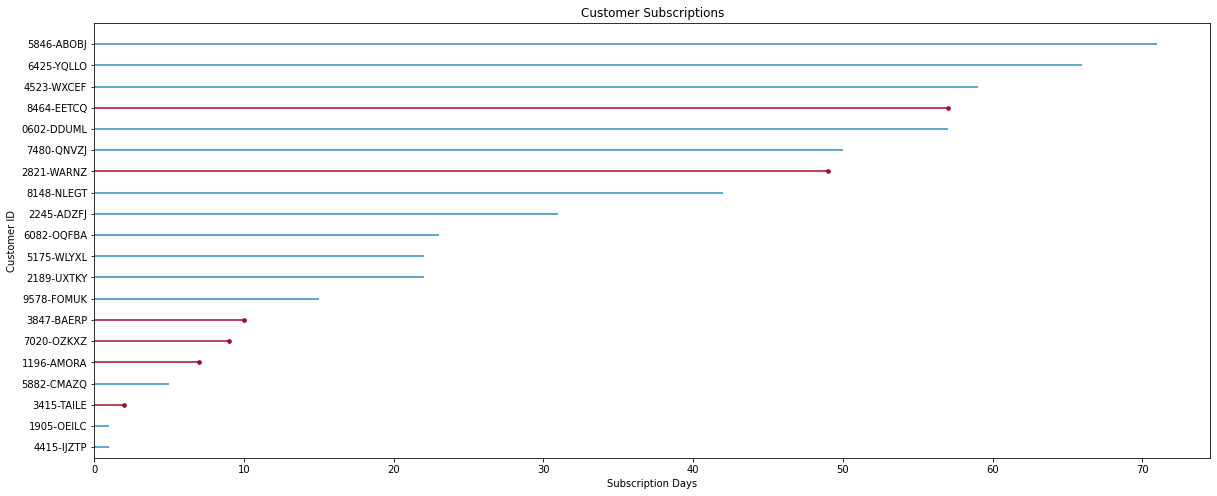

In [5]:
from lifelines.plotting import plot_lifetimes
time = Telcosdf_train["time"].sample(20, replace=False)
status = Telcosdf_train["status"].sample(20, replace=False)
plt.figure(figsize=(20,8))
plot_lifetimes(time, status)
plt.xlabel("Subscription Days")
plt.ylabel("Customer ID")
plt.title("Customer Subscriptions");


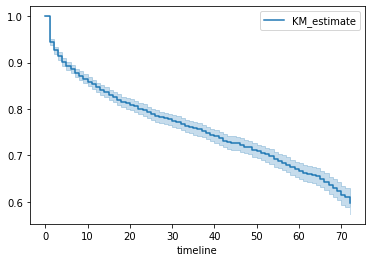

In [6]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
T = Telcosdf_train['time']
E = Telcosdf_train['status']
kmf = KaplanMeierFitter()
kmf.fit(T,E)
kmf.plot_survival_function();

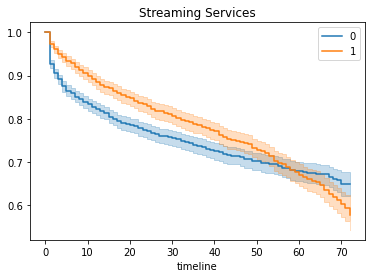

In [7]:
ax = plt.subplot(111)
group = 'StreamingTV_Yes'
for name, df in Telcosdf_train.groupby(group):
    ix = Telcosdf_train[group] == name
    kmf = KaplanMeierFitter()
    kmf.fit(T[ix], E[ix], alpha=0.05, label=name)
    kmf.plot_survival_function(ax=ax)
plt.title("Streaming Services");

In [14]:
Telcosdf1

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No


In [16]:
Telcosdf1['churn'] = pd.get_dummies(Telcosdf1["Churn"], drop_first=True)

In [19]:
Telcosdf2 = Telcosdf1[["tenure", "churn"]]
Telcosdf2.head()

,tenure,churn
customerID,,
7590-VHVEG,1,0
5575-GNVDE,34,0
3668-QPYBK,2,1
7795-CFOCW,45,0
9237-HQITU,2,1


<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'tenure'
                event col = 'churn'
      baseline estimation = breslow
   number of observations = 7043
number of events observed = 1869
   partial log-likelihood = -15653.04
         time fit was run = 2022-01-16 03:03:57 UTC

---
Empty DataFrame
Columns: [ coef,  exp(coef),  se(coef),  coef lower 95%,  coef upper 95%,  exp(coef) lower 95%,  exp(coef) upper 95%]
Index: []

Empty DataFrame
Columns: [ z,  p,  -log2(p)]
Index: []
---
Concordance = 0.50
Partial AIC = 31306.08
log-likelihood ratio test = 0.00 on 0 df
-log2(p) of ll-ratio test = nan

None


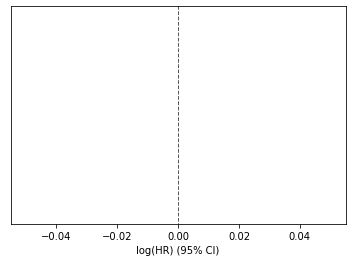

In [21]:
from lifelines import CoxPHFitter
cph = CoxPHFitter()
cph.fit(Telcosdf2, "tenure", event_col="churn")
print(cph.print_summary())
cph.plot();